In [197]:
import pandas as pd
import re
import cProfile
#from pycallgraph import PyCallGraph
#from pycallgraph.output import GraphvizOutput
from multiprocessing import Pool
import datetime
import collections
import numpy as np
% matplotlib inline

In [2]:
with open("../data/AP_train.txt") as f:
    AP_train = f.readlines()
    
#AP_train = AP_train[:1000]

In [3]:
def parse_file(AP_train, time_scaling):
    
    ap_train_df = pd.DataFrame.from_dict({'Index': [], 'Name':[], 'Author':[],
                                         'Year':[], 'Journal':[], 'Citations': []}, orient='columns')
    
    start = datetime.datetime.now()
    ap_train_list = []
    
    temp_dict = {}
    count = 0

    for line in AP_train:

        count += 1
        
        #if count == 1000: break
        if (count/len(AP_train) % 0.1 == 0): print (count/len(AP_train))

        if line == '\n': 
            #ap_train_df = ap_train_df.append(temp_dict, ignore_index=True)
            ap_train_list.append(temp_dict)
            temp_dict = {}

        #if re.match(r'^#index', line.strip()):
        if "#index" in line:

            #temp_dict['Index'] = (re.split(r'^#index', line.strip())[1]).strip()
            temp_dict['Index'] = line.strip().split('#index')[1].strip()

        #if re.match(r'^#\*', line.strip()):
        if '#*' in line:

            temp_dict['Title'] = (re.split(r'^#*', line.strip())[1]).strip()
            #temp_dict['Name'] = line.strip().split('#\*')[0].strip()

        #if re.match(r'^#\@', line.strip()): 
        if '#@' in line:

            #temp_dict['Author'] = (re.split(r'^#\@', line.strip())[1]).strip()
            temp_dict['Author'] = line.strip().split('#@')[1].strip().split(';')
            temp_dict['Author_str'] = line.strip().split('#@')[1].strip()

        #if re.match(r'^#t', line.strip()): 
        if '#t' in line:

            #temp_dict['Year'] = (re.split(r'^#t', line.strip())[1]).strip()
            temp_dict['Year'] = line.strip().split('#t')[1].strip()

        #if re.match(r'^#c', line.strip()):
        if '#!' in line:

            #temp_dict['Journal'] = (re.split(r'^#c', line.strip())[1]).strip()
            temp_dict['Abstract'] = line.strip().split('#!')[1].strip()
       
        if '#c' in line:

            #temp_dict['Journal'] = (re.split(r'^#c', line.strip())[1]).strip()
            temp_dict['Venue'] = line.strip().split('#c')[1].strip()


        #if re.match(r'#%', line.strip()): 
        if '#%' in line:

            if 'Citations' in temp_dict:

                #temp_dict['Citations'].append(re.split(r'^#%', line.strip())[1]).strip()
                temp_dict['Citations'].append(line.strip().split('#%')[1].strip())

            else:
                #temp_dict['Citations'] = [(re.split(r'^#%', line.strip())[1]).strip()]
                temp_dict['Citations'] = [line.strip().split('#%')[1].strip()]

        #print(temp_dict)
    
    end = datetime.datetime.now()
    time_taken = str(end - start)
    time_scaling.update({'length': len(AP_train), 'time taken': time_taken})
    
    return ap_train_list, time_scaling


In [4]:
ap_train_list, time_scaling = parse_file(AP_train, {})
ap_train_df = pd.DataFrame(ap_train_list)
ap_train_df = ap_train_df.set_index('Index')
ap_train_list = []

/opt/conda/lib/python3.6/re.py:212: FutureWarning: split() requires a non-empty pattern match.
  return _compile(pattern, flags).split(string, maxsplit)


In [6]:
ap_train_df.head()

,Abstract,Author,Author_str,Citations,Index,Title,Venue,Year
0,NaN,[Marjorie Richardson],Marjorie Richardson,NaN,1,* Book Review: Discover Linux,Linux Journal,1998
1,NaN,[],,NaN,2,* MOSFET table look-up models for circuit simu...,"Integration, the VLSI Journal",1984
2,NaN,[Virgil D. Gligor],Virgil D. Gligor,NaN,3,* The verification of the protection mechanism...,International Journal of Parallel Programming,1984
3,NaN,"[M. Gyssens, J. Paredaens]",M. Gyssens;J. Paredaens,NaN,4,* Another view of functional and multivalued d...,International Journal of Parallel Programming,1984
4,NaN,"[Sushil Jajodia, Peter A. Ng, Frederick N. Spr...",Sushil Jajodia;Peter A. Ng;Frederick N. Spring...,NaN,5,* Entity-relationship diagrams which are in BCNF,International Journal of Parallel Programming,1984


#### A. Compute the number of distinct authors, publication venues, publications, and citations/references

In [18]:
print ('Distinct Titles: ' + str(len(ap_train_df['Title'].unique()))
      + '\nDistict Venues: ' + str(len(ap_train_df['Venue'].unique())))

Distinct Titles: 1929487
Distict Venues: 255688


In [19]:
all_citations = []
for sublist in list(ap_train_df['Citations']):
    if sublist == sublist:
        for item in sublist:
            all_citations.append(item)

In [20]:
print ('The number of unique citations: ' + str(len(set(all_citations))))

The number of unique citations: 871092


In [21]:
all_authors = []
for sublist in list(ap_train_df['Author']):
    if sublist == sublist:
        for item in sublist:
            if item != '': all_authors.append(item)

#all_authors = list(all_authors)

In [22]:
print ('The number of unique authors: ' + str(len(set(all_authors))))

The number of unique authors: 1483291


#### Are these numbers likely to be accurate? As an example look up all the publications venue names associated with the conference “Principles and Practice of Knowledge Discovery in Databases”13 – what do you notice?

In [15]:
venue_temp = ap_train_df.loc\
                [ap_train_df['Venue'].str.contains\
                 ('Principles and Practice of Knowledge Discovery in Databases'), 'Venue']

In [17]:
for name in venue_temp: print (name)

PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice of Knowledge Discovery in Databases
PKDD '04 Proceedings of the 8th European Conference on Principles and Practice o

In [23]:
cnt = collections.Counter()
for author in all_authors:
    cnt[author] += 1

In [24]:
cnt.most_common(5)

[('Wei Wang', 1056),
 ('Lei Zhang', 756),
 ('Staff', 737),
 ('Wei Zhang', 690),
 ('Wei Li', 685)]

In [25]:
author_count = dict(cnt)
author_count = pd.DataFrame.from_dict(list(author_count.items()))
author_count.columns = ['Author', 'Count']

In [26]:
author_count['Count Log'] = np.log(author_count['Count'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe925029da0>]], dtype=object)

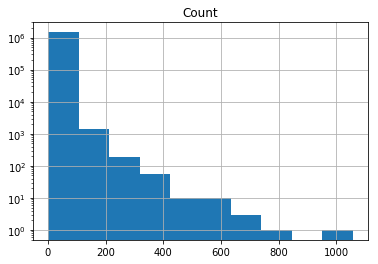

In [29]:
author_count.hist(column='Count', bins = 10, log = True)

#### D. Calculate the mean and standard deviation of the number of publications per author. Also calculate the Q1 (1st quartile14), Q2 (2nd quartile, or median) and Q3 (3rd quartile) values. Compare the median to the mean and explain the difference between the two values based on the standard deviation and the 1st and 3rd quartiles.

In [30]:
print ('The mean Publications per author is: ' + str(author_count['Count'].mean()))
print ('The Standard Deviation of Publications per author is: ' + str(author_count['Count'].std()))
print ('The Median of Publications per author is: ' + str(author_count['Count'].median()))
print ('The First Quantile of Publications per author is: ' + str(author_count['Count'].quantile(.25)))
print ('The Second Quantile of Publications per author is: ' + str(author_count['Count'].quantile(.50)))
print ('The Third Quantile of Publications per author is: ' + str(author_count['Count'].quantile(.75)))

The mean Publications per author is: 3.281668937517992
The Standard Deviation of Publications per author is: 8.83637248626611
The Median of Publications per author is: 1.0
The First Quantile of Publications per author is: 1.0
The Second Quantile of Publications per author is: 1.0
The Third Quantile of Publications per author is: 2.0


This looks like a classic example of the 'long tail' situation, where most of the publications are written by very few authors.

#### E. Now plot a histogram of the number of publications per venue, as well as calculate the mean, standard deviation, median, Q1, and Q3 values. What is the venue with the largest number of publications in the dataset?

In [31]:
cnt = collections.Counter()
for venue in list(ap_train_df['Venue']):
    cnt[venue] += 1
cnt.most_common()

[('IEEE Transactions on Information Theory', 11227),
 ('IEEE Transactions on Signal Processing', 8274),
 ('Communications of the ACM', 8140),
 ('Automatica (Journal of IFAC)', 7411),
 ('Journal of Computational Physics', 7355),
 ('IEEE Transactions on Computers', 7335),
 ('Computer', 6422),
 ('Expert Systems with Applications: An International Journal', 6392),
 ('Journal of Computational and Applied Mathematics', 6366),
 ('Bioinformatics', 6332),
 ('Theoretical Computer Science', 6329),
 ('Microelectronic Engineering', 5907),
 ('Mathematical and Computer Modelling: An International Journal', 5776),
 ('Information Processing Letters', 5491),
 ('IEEE Transactions on Consumer Electronics', 5321),
 ('IEEE Communications Magazine', 5037),
 ('Computer Communications', 4872),
 ('Fuzzy Sets and Systems', 4734),
 ('IEEE Spectrum', 4544),
 ('IEEE Transactions on Pattern Analysis and Machine Intelligence', 4471),
 ('IEEE Journal on Selected Areas in Communications', 4431),
 ('Discrete Mathematics

In [32]:
venue_count = dict(cnt)
venue_count = pd.DataFrame().from_dict(list(venue_count.items()))
venue_count.columns = ['Venue', 'Count']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe91d290a90>]], dtype=object)

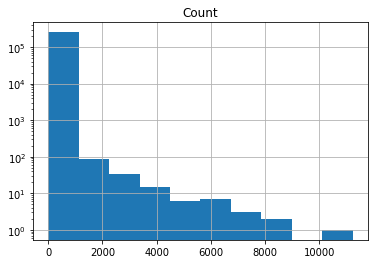

In [33]:
venue_count.hist(column='Count', bins = 10, log = True)

#### F. Plot a histogram of the number of references (number of publications a publication refers to) and citations (number of publications referring to a publication) per publication. What is the publication with the largest number of references? What is the publication with the largest number of citations? Do these make sense?

In [97]:
cnt = collections.Counter()
for citation in all_citations:
    cnt[citation] += 1

cnt.most_common()
references_count = dict(cnt)
references_count = pd.DataFrame().from_dict(list(references_count.items()))
references_count.columns = ['Pub_Index', 'Count']
references_count = references_count.set_index('Pub_Index')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8fe0e1da0>]], dtype=object)

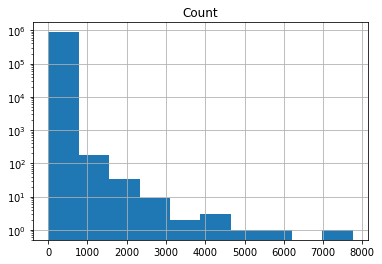

In [79]:
references_count.hist(column = 'Count', bins = 10, log = True)

In [98]:
references_count

,Count
Pub_Index,
289259,26
289024,21
408638,1917
600828,5
688897,1
769,8
289452,9
319821,42
408343,538


In [99]:
references_count = references_count.join(ap_train_df, how = 'left')
references_count.sort_values('Count', ascending = False)

,Count,Abstract,Author,Author_str,Citations,Title,Venue,Year
Pub_Index,,,,,,,,
408396,7753,NaN,"[Michael R. Garey, David S. Johnson]",Michael R. Garey;David S. Johnson,NaN,* Computers and Intractability: A Guide to the...,Computers and Intractability: A Guide to the T...,1979
369236,5891,From the Publisher:This book brings together -...,[David E. Goldberg],David E. Goldberg,NaN,"* Genetic Algorithms in Search, Optimization a...","Genetic Algorithms in Search, Optimization and...",1989
190581,4748,NaN,[Vladimir N. Vapnik],Vladimir N. Vapnik,NaN,* The nature of statistical learning theory,The nature of statistical learning theory,1995
136350,4399,NaN,[J. Ross Quinlan],J. Ross Quinlan,NaN,* C4.5: programs for machine learning,C4.5: programs for machine learning,1993
168251,4336,NaN,"[Erich Gamma, Richard Helm, Ralph Johnson, Joh...",Erich Gamma;Richard Helm;Ralph Johnson;John Vl...,NaN,* Design patterns: elements of reusable object...,Design patterns: elements of reusable object-o...,1995
729437,3951,NaN,"[Richard O. Duda, Peter E. Hart, David G. Stork]",Richard O. Duda;Peter E. Hart;David G. Stork,NaN,* Pattern Classification (2nd Edition),Pattern Classification (2nd Edition),2000
760805,3358,This paper presents a method for extracting di...,[David G. Lowe],David G. Lowe,"[90846, 103572, 146347, 154675, 198350, 227526...",* Distinctive Image Features from Scale-Invari...,International Journal of Computer Vision,2004
115608,3203,NaN,"[Thomas M. Cover, Joy A. Thomas]",Thomas M. Cover;Joy A. Thomas,NaN,* Elements of information theory,Elements of information theory,1991
44876,3089,NaN,[Judea Pearl],Judea Pearl,NaN,* Probabilistic reasoning in intelligent syste...,Probabilistic reasoning in intelligent systems...,1988


In [218]:
cnt = collections.Counter()

for index, value in ap_train_df.iterrows():
    if value['Citations'] == value['Citations']: cnt[index] += len(value['Citations'])
    
cnt.most_common()
citations_count = dict(cnt)
citations_count = pd.DataFrame().from_dict(list(citations_count.items()))
citations_count.columns = ['Pub_Index', 'Citation Count']
citations_count = citations_count.set_index('Pub_Index')

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8e87deda0>]], dtype=object)

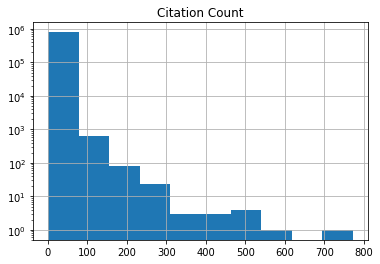

In [219]:
citations_count.hist(column = 'Citation Count', bins = 10, log = True)

In [220]:
#CHECK THIS
citations_count = citations_count.join(ap_train_df, how = 'right')
citations_count.sort_values('Citation Count', ascending = False)

,Citation Count,Abstract,Author,Author_str,Citations,Title,Venue,Year
Index,,,,,,,,
719353,772.0,NaN,"[Johannes Grabmeier, Erich Kaltofen, Volker We...",Johannes Grabmeier;Erich Kaltofen;Volker Weisp...,"[293, 767, 858, 1363, 1460, 1807, 1825, 2172, ...",* Cited References,Computer algebra handbook,2003
1221204,555.0,Modern electronics testing has a legacy of mor...,[Wang],Wang,"[1366, 4186, 20376, 27800, 29137, 32251, 55298...",* System-on-Chip Test Architectures: Nanometer...,System-on-Chip Test Architectures: Nanometer D...,2007
1583653,527.0,NaN,"[Andreas Kerren, Achim Ebert, Jörg Meyer]",Andreas Kerren;Achim Ebert;Jörg Meyer,"[1335, 15354, 18033, 18040, 28099, 39314, 3931...",* Human-centered visualization environments,Human-centered visualization environments,2006
1376720,524.0,NaN,"[Ulrich Meyer, Peter Sanders, Jop Sibeyn]",Ulrich Meyer;Peter Sanders;Jop Sibeyn,"[672, 735, 1156, 1679, 1727, 2115, 2194, 3623,...",* Algorithms for memory hierarchies: advanced ...,Algorithms for memory hierarchies: advanced le...,2003
1221200,523.0,The main characteristic of Reconfigurable Comp...,"[Scott Hauck, Andre DeHon]",Scott Hauck;Andre DeHon,"[1791, 2647, 3406, 3888, 18580, 22508, 25444, ...",* Reconfigurable Computing: The Theory and Pra...,Reconfigurable Computing: The Theory and Pract...,2007
932477,476.0,"Over the past decade, system-on-chip (SoC) des...","[Giovanni De Micheli, Luca Benini]",Giovanni De Micheli;Luca Benini,"[2236, 2991, 3873, 14999, 22360, 25444, 46262,...",* On-Chip Communication Architectures: System ...,On-Chip Communication Architectures: System on...,2008
1504996,435.0,NaN,"[Matthias Muller-Hannemann, Stefan Schirra]",Matthias Muller-Hannemann;Stefan Schirra,"[212, 1156, 1436, 3651, 4840, 5672, 6585, 6838...",* Algorithm engineering: bridging the gap betw...,Algorithm engineering: bridging the gap betwee...,2010
936367,412.0,Visualization in Medicine is the first book on...,"[Bernhard Preim, Dirk Bartz]",Bernhard Preim;Dirk Bartz,"[2740, 12175, 12745, 18033, 31702, 31703, 3667...","* Visualization in Medicine: Theory, Algorithm...","Visualization in Medicine: Theory, Algorithms,...",2007
1442657,408.0,NaN,"[Matthew M. Huntbach, Graem A. Ringwood]",Matthew M. Huntbach;Graem A. Ringwood,"[103, 241, 575, 877, 958, 1012, 1072, 1412, 15...",* Agent-oriented programming: from prolog to g...,Agent-oriented programming: from prolog to gua...,1999


The publications for the most number of citations seems to be a generic placeholder for citations. 

### G. Calculate the so called “impact” factor for each venue. To do so, calculate the total number of citations for the publications in the venue, and then divide this number by the number of publications for the venue. Plot a histogram of the results

In [175]:
venue_citations_df = citations_count[['Citation Count', 'Venue']].groupby(['Venue']).sum()
venue_citations_df = venue_citations_df.join(ap_train_df[['Venue','Author']].groupby(['Venue']).count(), how='right').fillna(0)

In [180]:
venue_citations_df.columns = ['Citation Count', 'Publication Count']
venue_citations_df['Impact Factor'] = venue_citations_df['Citation Count'] / venue_citations_df['Publication Count']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe931502fd0>]], dtype=object)

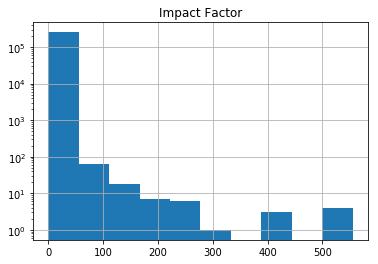

In [181]:
venue_citations_df.hist(column = 'Impact Factor', bins = 10, log = True)

#### H. What is the venue with the highest apparent impact factor? Do you believe this number?(http://mdanderson.libanswers.com/faq/26159)

In [182]:
venue_citations_df.sort_values('Impact Factor', ascending = False)

,Citation Count,Publication Count,Impact Factor
Venue,,,
System-on-Chip Test Architectures: Nanometer Design for Testability,555.0,1,555.0
Human-centered visualization environments,527.0,1,527.0
Algorithms for memory hierarchies: advanced lectures,524.0,1,524.0
Reconfigurable Computing: The Theory and Practice of FPGA-Based Computation,523.0,1,523.0
Algorithm engineering: bridging the gap between algorithm theory and practice,435.0,1,435.0
"Visualization in Medicine: Theory, Algorithms, and Applications",412.0,1,412.0
Agent-oriented programming: from prolog to guarded definite clauses,408.0,1,408.0
No Code Required: Giving Users Tools to Transform the Web,311.0,1,311.0
Networked Graphics: Building Networked Games and Virtual Environments,273.0,1,273.0


The list is likely to be erroneus as the denomitor of 1 can skew the results.

#### I. Now repeat the calculation from item b., but restrict the calculation to venues with at least 10 publications. How does your histogram change? List the citation counts for all publications from the venue with the highest impact factor. How does the impact factor (mean number of citations) compare to the median number of citations?

In [183]:
venue_citations_df = venue_citations_df.loc[venue_citations_df['Publication Count'] > 10]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe8d4dcdc88>]], dtype=object)

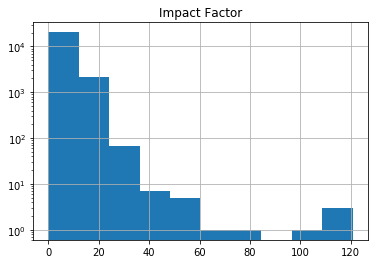

In [184]:
venue_citations_df.hist(column = 'Impact Factor', bins = 10, log = True)

In [185]:
venue_citations_df.sort_values('Impact Factor', ascending = False)

,Citation Count,Publication Count,Impact Factor
Venue,,,
Foundations and Trends in Information Retrieval,2052.0,17,120.705882
Foundations and Trends in Human-Computer Interaction,1690.0,15,112.666667
Foundations and Trends in Databases,1215.0,11,110.454545
Foundations and Trends® in Computer Graphics and Vision,1988.0,20,99.400000
Foundations and Trends® in Theoretical Computer Science,1158.0,15,77.200000
Foundations and Trends® in Machine Learning,725.0,12,60.416667
A 25-year perspective on logic programming,842.0,14,60.142857
Foundations and Trends in Electronic Design Automation,833.0,14,59.500000
Foundations and Trends in Communications and Information Theory,678.0,13,52.153846


In [186]:
print (venue_citations_df['Citation Count'].mean())
print(venue_citations_df['Citation Count'].median())

310.7176361468133
97.0


#### J. Finally, construct a list of publications for each publication year. Use this list to plot the average number of references and average number of citations per publication as a function of time. Explain the differences you see in the trends.

In [221]:
citations_count = citations_count.loc[citations_count['Year'].str.match('[0-9+]')]

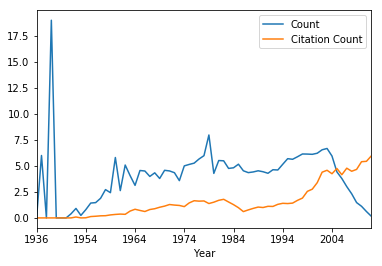

In [222]:
references_count[['Count']]\
    .join(citations_count[['Citation Count', 'Year']], how = 'right')\
    .fillna(0)\
    .groupby('Year')\
    .mean()\
    .plot()